Converts steamdb timeseries (prices when changed at timestamps) to standardized time series where the date is part of the week. <br>
Divide into weeks

Plan:<br>
*convert to minimum time series
*divide into weeks



In [23]:
import os
from pprint import pprint as pp
import pandas as pd
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import copy
import pymysql as mdb
%matplotlib inline
os.getcwd()

'/home/ryan/Documents/insight_projects/steam_prices/data_analysis'

In [3]:
df = pd.read_pickle('df_steam_db.pkl')


In [4]:
'''fixing timestamps'''
df['price_date_fixed'] = df.price_date.apply(np.array)
df.price_date_fixed = df.price_date_fixed * pow(10,-3)
df.head()

,appid,fprice,iprice,price_date,min_fprice,min_iprice,min_iprice_var,min_iprice_slope,min_iprice_intercept,price_date_fixed
0,2430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,297750,"[39.99, 29.99, 29.99, 19.99, 19.99]","[39.99, 39.99, 39.99, 39.99, 39.99]","[1.417120656e+12, 1.434047268e+12, 1.434994431...","[39.99, 29.99, 29.99, 19.99, 19.99]","[39.99, 39.99, 39.99, 39.99, 39.99]",0.000000e+00,0,39.99,"[1417120656.0, 1434047268.0, 1434994431.0, 144..."
2,19080,"[9.99, 2.49, 2.49]","[9.99, 9.99, 9.99]","[1.417120656e+12, 1.434049315e+12, 1.434996542...","[9.99, 2.49, 2.49]","[9.99, 9.99, 9.99]",0.000000e+00,0,9.99,"[1417120656.0, 1434049315.0, 1434996542.0]"
3,278850,"[4.99, 2.49, 2.49, 2.49, 2.49, 1.49, 1.49]","[4.99, 4.99, 4.99, 4.99, 4.99, 4.99, 4.99]","[1.417120656e+12, 1.417513376e+12, 1.417545207...","[4.99, 2.49, 2.49, 2.49, 2.49, 1.49, 1.49]","[4.99, 4.99, 4.99, 4.99, 4.99, 4.99, 4.99]",7.888609e-31,0,4.99,"[1417120656.0, 1417513376.0, 1417545207.0, 141..."
4,367260,"[5.39, 5.39, 4.01, 4.01, 4.01, 4.01, 4.01, 4.01]","[5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99]","[1.430513702e+12, 1.431104712e+12, 1.43404599e...","[5.39, 5.39, 4.01, 4.01, 4.01, 4.01, 4.01, 4.01]","[5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99]",7.888609e-31,0,5.99,"[1430513702.0, 1431104712.0, 1434045990.0, 143..."


In [5]:

def timestamptodays(timestamp_vec):
    '''time stamps to days. Not sure if it is still being used. Check later'''
    if type(timestamp_vec) is float:
        s_ts = np.array(timestamp_vec) * pow(10,-3) #for some reason, the timestamps were saved with 3 extra zeros
        s_ts = s_ts - s_ts[0]
        s_ts = s_ts / (60*60*24) #divide by seconds in a day        
    else:
        s_ts = np.nan
    return s_ts

In [6]:
'''determine the minimum timestamp in the series'''

def get_min(in_list):
    if not np.array(in_list).size == 1: #all timestamps with nan are equalt to size 1.
        #not sure if others are (need to check)
        s_ts = np.array(in_list) * pow(10,-3)
        min_val = np.min(np.array(s_ts))
        
    else:
        min_val = np.inf
    return min_val

'''THIS DOESN'T FOLLOW THE DON'T REPEAT YOURSELF RULE, BUT IN A CRUNCH. GO BACK LATER AND CHANGE'''
def get_max(in_list):
    if not np.array(in_list).size == 1: #all timestamps with nan are equalt to size 1. 
                                        #not sure if others are (need to check)
        s_ts = np.array(in_list) * pow(10,-3)
        max_val = np.max(np.array(s_ts))
        
    else:
        max_val = -np.inf
    return max_val
min_timestamp = int(df.price_date.apply(get_min).min())
max_timestamp = int(df.price_date.apply(get_max).max())

print min_timestamp
print max_timestamp

1417120656
1442077561


In [14]:
def convert_to_biweekly(pdfi, ipi, fpi):
    '''
    pdfi: price_dates (in timestamps)
    ipi: initial prices
    fpi: final prices
    
    make sure to input with the fixed time stamps
    '''
    #pdfi = df.price_date_fixed.iloc[samp]
    #ipi = np.array(df.iprice.iloc[samp])
    #fpi = np.array(df.fprice.iloc[samp])
    #dt = np.append(np.array(pdfi),(np.array(pdfi) + day_sec/10))
    dt = np.array(pdfi)
    price = np.append(ipi,fpi)
    price_type = ['i'] * ipi.size + ['f'] * fpi.size

    #df_dp = pd.DataFrame({'price':price,'timestamp':dt, 'price_type':price_type}).sort(['timestamp'])

    week_sec = 7 * 24 * 60 * 60
    #day_sec = 24 * 60 * 60
    timestamp_range = np.arange(min_timestamp,max_timestamp,week_sec / 2)



    price_val = np.empty(timestamp_range.size)
    price_val[:] = np.nan


    for i,v in np.ndenumerate(dt):#make sure s_ts is a 1-D numpy array
        time_delta =  np.abs(v - timestamp_range)
        min_dif = np.argmin(time_delta)
        if min_dif.size == 1:
            dif_ix = int(min_dif)
        else:
            dif_ix = int(min_dif[0])
        price_val[dif_ix] = ipi[i]
        if not dif_ix + 1 > fpi.size:
            price_val[dif_ix + 1] = fpi[i]
        


    price_val_reverse = copy.deepcopy(price_val[::-1])
    price_val_reverse2 = price_val_reverse #for inputting new values into during iteration
    for i,v in np.ndenumerate(price_val_reverse):
        if i[0] > 0 and np.isnan(v):
            price_val_reverse2[i[0]] = price_val_reverse2[i[0]-1]

    '''fill in trailing nans'''
    price_val2 = price_val_reverse2[::-1]
    price_val3 = copy.deepcopy(price_val2)
    for i,v in np.ndenumerate(price_val3):
        if i[0] > 1 and np.isnan(v):
            price_val3[i[0]] = np.median(price_val3[:i[0]-1]) # this will need to be fixed! 
            #Currently only doing medians
    
    out_dict = {'timestamps':list(timestamp_range), 'prices':list(price_val3)}
    return out_dict



In [15]:
out_dict_list =list()
for r in df.iterrows():
    row = r[1]
    pdfi = row.price_date_fixed
    ipi = np.array(row.iprice)
    fpi = np.array(row.fprice)
    
    out_dict_list.append(convert_to_biweekly(pdfi, ipi,fpi))
    

In [16]:
df['plot_info'] =out_dict_list

In [31]:
pw_path =  '/home/ryan/credentials/'
with open(os.path.join(pw_path, 'mysql_pw.txt')) as f:
    pw = f.read().strip('\n')
        
db = mdb.connect(user="root", host="localhost", passwd=pw, db="gamepricepred", charset='utf8')

for r in df.iterrows():
    
    row = r[1]
    x = row.plot_info['timestamps']
    y = row.plot_info['prices']
    print row.appid
    with db:
        cur = db.cursor()
        str_x= '"' + str(x) + '"'
        str_y= '"' + str(y) + '"'
        cur.execute("UPDATE Games SET plot_x = %s WHERE Appid='%s';" % (str_x,row.appid))
        cur.execute("UPDATE Games SET plot_y = %s WHERE Appid='%s';" % (str_y,row.appid))


2430
297750
19080
278850
367260
251970
293860
2390
291910
231160
366890
1280
346680
39900
270090
313080
261640
253630
262870
294720
208480
333600
51000
366350
367050
298140
371890
71260
208710
231720
9200
272490
47790
337760
201490
286120
328310
303940
323720
377470
337630
32740
248550
326470
349720
294060
110600
91200
21120
348960
244910
11150
94520
270850
236110
237430
254480
39680
9980
249570
235700
282620
372930
282680
395480
262060
266450
293480
269650
331470
356000
278640
286320
281820
327410
40500
204060
12250
394270
550
39150
361660
35420
356270
290750
358090
29110
19500
348670
342300
17120
238890
358270
335560
51060
358230
296910
353940
355100
345180
249870
312410
28050
233680
204860
358320
63000
299540
296070
334980
367300
308320
395930
342520
217080
390570
207530
271670
348650
55020
204390
370750
99810
314240
91900
328140
44620
21900
276360
20570
224440
312230
368930
16450
354920
61520
332810
397620
313470
303680
296510
250580
251310
211970
200260
269770
6870
225020
378830
3

In [27]:
json_str

'"{"prices": [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], "timestamps": [1417120656, 1417423056, 1417725456, 1418027856, 1418330256, 1418632656, 1418935056, 1419237456, 1419539856, 1419842256, 1420144656, 1420447056, 1420749456, 1421051856, 1421354256, 1421656656, 1421959056, 1422261456, 1422563856, 1422866256, 1423168656, 1423471056, 1423773456, 1424075856, 1424378256, 1424680656, 1424983056, 1425285456, 1425587856, 1425890256, 1426192656, 1426495056, 1426797456, 1427099856, 1427402256, 1427704656, 1428007056, 1428309456, 1428611856, 1428914256, 1429216656, 1429519056, 1429821456, 1430123856, 1430426256, 1430728656, 143

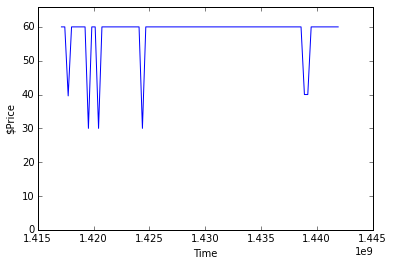

In [58]:


samp = df['plot_info'].iloc[16]
def make_plot(plot_dict):
    x = plot_dict['timestamps']
    y = plot_dict['prices']

    fig = plt.plot(x,y)
    plt.ylim([0,np.max(y) + np.max(y) * 0.10])
    plt.xlabel('Time')
    plt.ylabel('$Price')
    return fig
fig = make_plot(samp)

In [ ]:
'''more testing'''


In [55]:
a 

{'prices': array([ 59.99,  59.99,  39.59,  59.99,  59.99,  59.99,  59.99,  59.99,
        29.99,  59.99,  59.99,  29.99,  59.99,  59.99,  59.99,  59.99,
        59.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,
        29.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,
        59.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,
        59.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,
        59.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,
        59.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,
        59.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,
        39.99,  39.99,  59.99,  59.99,  59.99,  59.99,  59.99,  59.99,
        59.99,  59.99,  59.99]), 'timestamps': array([1417120656, 1417423056, 1417725456, 1418027856, 1418330256,
       1418632656, 1418935056, 1419237456, 1419539856, 1419842256,
       1420144656, 1420447056, 1420749456, 1421051856, 1421354256,
       1421656656, 1421959056, 

NameError: name 'array' is not defined